# CTGAN Training: Synthetic Data Generation

## Overview

This notebook implements a Conditional Tabular GAN (CTGAN) for generating synthetic aviation emissions data. The CTGAN is specifically designed for tabular data and preserves statistical properties while generating realistic synthetic samples.

## Objectives

1. Load and prepare training data
2. Initialize CTGAN models (generator and discriminator)
3. Train the GAN with Wasserstein loss
4. Generate 5x synthetic data augmentation
5. Validate synthetic data quality
6. Save trained models and synthetic data

## Setup

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Import src modules
from src.models import build_ctgan  # Builds CTGAN with generator and discriminator
from src.training import train_ctgan, generate_synthetic_data
from src.evaluation import kolmogorov_smirnov_test

# Set style
sns.set_style('whitegrid')
np.random.seed(42)
tf.random.set_seed(42)

print(f'TensorFlow: {tf.__version__}')
print('Libraries and modules imported successfully!')

TensorFlow: 2.20.0
Libraries and modules imported successfully!


## 1. Load & Prepare Data

In [2]:
# Load unscaled training data for CTGAN
# CTGAN works better with unscaled data to preserve distribution properties
train_data_unscaled = pd.read_csv('../data/processed/train_data_unscaled.csv')

# Convert boolean columns to integers (0, 1) for Keras compatibility
bool_columns = train_data_unscaled.select_dtypes(include=['bool']).columns
train_data_unscaled[bool_columns] = train_data_unscaled[bool_columns].astype(int)

# Convert all data to float32 for TensorFlow compatibility
train_data_unscaled = train_data_unscaled.astype('float32')

# Scale data to [-1, 1] range for tanh activation
# Store min/max for inverse transform later
data_min = train_data_unscaled.min()
data_max = train_data_unscaled.max()

# Avoid division by zero for constant columns
data_range = data_max - data_min
data_range[data_range == 0] = 1.0

train_data_scaled = 2 * (train_data_unscaled - data_min) / data_range - 1

print(f'Training data shape: {train_data_scaled.shape}')
print(f'\nFeatures: {list(train_data_scaled.columns)}')
print(f'\nData types check:')
print(f'  Boolean columns converted: {len(bool_columns)}')
print(f'  All float32: {(train_data_scaled.dtypes == "float32").all()}')
print(f'\nData range after scaling:')
print(f'  Min: {train_data_scaled.min().min():.4f}')
print(f'  Max: {train_data_scaled.max().max():.4f}')
print(f'\nFirst few rows (scaled):')
print(train_data_scaled.head())

Training data shape: (3500, 26)

Features: ['altitude_ft', 'speed_knots', 'weight_tons', 'route_distance_nm', 'temperature_c', 'wind_speed_knots', 'speed_weight_ratio', 'is_heavy', 'wind_impact', 'aircraft_A320', 'aircraft_A321', 'aircraft_A380', 'aircraft_B737', 'aircraft_B738', 'aircraft_B777', 'aircraft_B787', 'phase_approach', 'phase_climb', 'phase_cruise', 'phase_descent', 'phase_taxi', 'alt_cat_low', 'alt_cat_medium', 'alt_cat_high', 'alt_cat_very_high', 'co2_kg']

Data types check:
  Boolean columns converted: 16
  All float32: True

Data range after scaling:
  Min: -1.0000
  Max: 1.0000

First few rows (scaled):
   altitude_ft  speed_knots  weight_tons  route_distance_nm  temperature_c  \
0     0.592573     0.750636    -0.863419          -0.294354       0.076810   
1    -0.937150    -0.251904    -0.855602          -0.864911       0.059608   
2    -0.946347    -0.549761    -0.898521           0.952150      -0.261791   
3     0.014292     0.221405    -0.882889          -0.159091 

## 2. Initialize CTGAN Model

In [3]:
# Build CTGAN using src.models.build_ctgan()
# Creates generator and discriminator with Wasserstein loss
data_dim = train_data_scaled.shape[1]  # Number of features

ctgan = build_ctgan(
    data_dim=data_dim,
    noise_dim=100,
    condition_dim=0,  # Set > 0 for conditional generation
    generator_lr=2e-4,
    discriminator_lr=2e-4
)

print(f'\nCTGAN initialized with {data_dim} features')
print(f'Data scaled to [-1, 1] range for tanh generator output')

CTGAN model built successfully!
  Data dimension: 26
  Noise dimension: 100
  Condition dimension: 0

CTGAN initialized with 26 features
Data scaled to [-1, 1] range for tanh generator output


## 3. Train CTGAN

In [4]:
# Train CTGAN using src.training.train_ctgan()
# Uses Wasserstein distance with gradient penalty
print('Training CTGAN...')
history = train_ctgan(
    ctgan,
    real_data=train_data_scaled.values,  # Use scaled data
    epochs=100,
    batch_size=256,
    n_critic=5,  # Train discriminator 5x per generator update
    verbose=True
)

print('\nTraining completed!')

Training CTGAN...


Training CTGAN: 100%|██████████| 100/100 [02:10<00:00,  1.31s/it, G_loss=-1.4180, D_loss=-0.8142, W_dist=-0.9690]


Training completed!


## 4. Visualize Training Progress

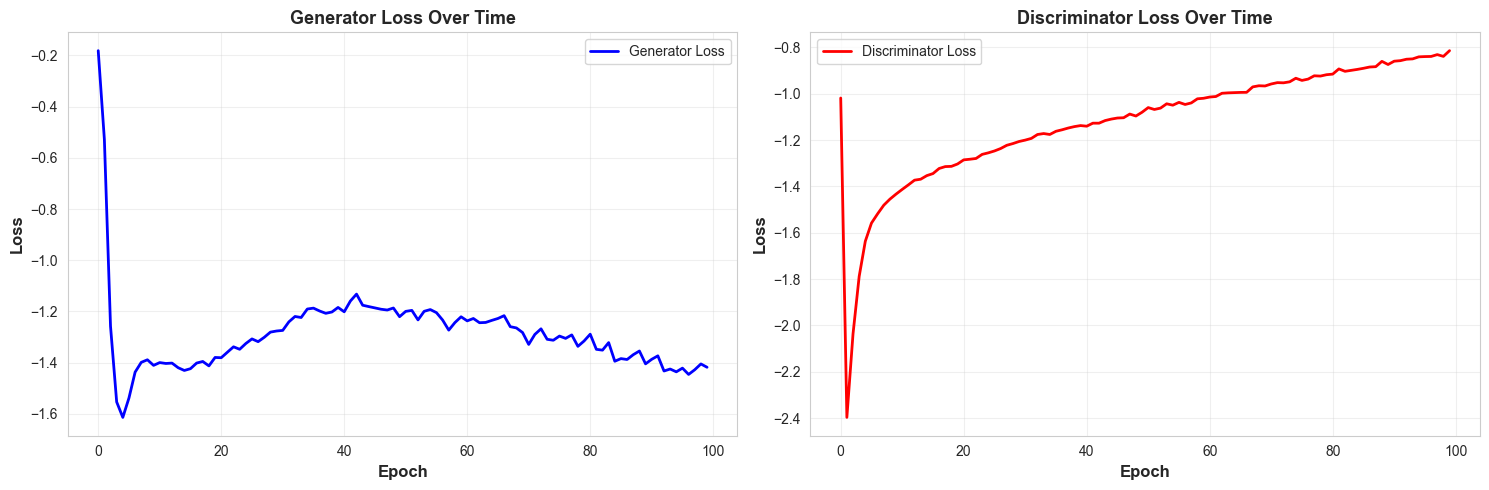

In [5]:
# Plot training losses
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['g_loss'], linewidth=2, color='blue', label='Generator Loss')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Generator Loss Over Time', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(history['d_loss'], linewidth=2, color='red', label='Discriminator Loss')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].set_title('Discriminator Loss Over Time', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('../plots/ctgan_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

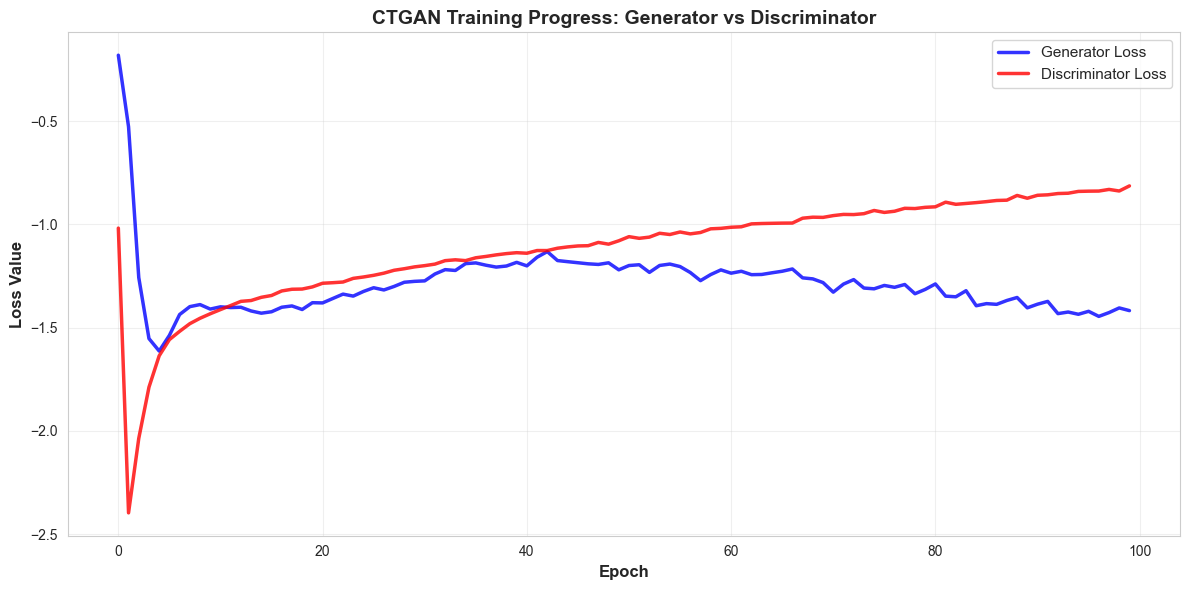

Final Generator Loss: -1.4180
Final Discriminator Loss: -0.8142


In [6]:
# Combined loss plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(history['g_loss'], linewidth=2.5, label='Generator Loss', color='blue', alpha=0.8)
ax.plot(history['d_loss'], linewidth=2.5, label='Discriminator Loss', color='red', alpha=0.8)

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss Value', fontsize=12, fontweight='bold')
ax.set_title('CTGAN Training Progress: Generator vs Discriminator', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='best')

plt.tight_layout()
plt.savefig('../plots/ctgan_combined_loss.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Final Generator Loss: {history["g_loss"][-1]:.4f}')
print(f'Final Discriminator Loss: {history["d_loss"][-1]:.4f}')

## 5. Generate Synthetic Data

In [7]:
# Generate 5x synthetic data for augmentation
num_real_samples = len(train_data_unscaled)
num_synthetic_samples = 5 * num_real_samples

print(f'Generating {num_synthetic_samples:,} synthetic samples (5x augmentation)...')
synthetic_data = generate_synthetic_data(
    ctgan,
    n_samples=num_synthetic_samples,
    condition=None
)

# Convert to DataFrame
synthetic_df_scaled = pd.DataFrame(
    synthetic_data,
    columns=train_data_scaled.columns
)

# Inverse transform from [-1, 1] back to original scale
# Ensure data_range and data_min are aligned with column order
synthetic_df = pd.DataFrame(index=synthetic_df_scaled.index, columns=synthetic_df_scaled.columns)
for col in synthetic_df_scaled.columns:
    synthetic_df[col] = (synthetic_df_scaled[col] + 1) / 2 * data_range[col] + data_min[col]

# Convert to float32 to match original data type
synthetic_df = synthetic_df.astype('float32')

print(f'\n✓ Synthetic data generated and inverse transformed!')
print(f'Shape: {synthetic_df.shape}')
print(f'\nSynthetic data range (after inverse transform):')
print(f'  Min: {synthetic_df.min().min():.4f}')
print(f'  Max: {synthetic_df.max().max():.4f}')
print(f'\nOriginal data range for comparison:')
print(f'  Min: {train_data_unscaled.min().min():.4f}')
print(f'  Max: {train_data_unscaled.max().max():.4f}')
print(f'\nFirst few rows:')
print(synthetic_df.head())

Generating 17,500 synthetic samples (5x augmentation)...

✓ Synthetic data generated and inverse transformed!
Shape: (17500, 26)

Synthetic data range (after inverse transform):
  Min: -49.8836
  Max: 41990.3203

Original data range for comparison:
  Min: -49.9933
  Max: 41990.9531

First few rows:
    altitude_ft  speed_knots  weight_tons  route_distance_nm  temperature_c  \
0  28504.148438   310.694092    49.637787        2507.242920     -35.427204   
1    173.406937    32.758877    47.064888        4148.651367     -12.607492   
2     13.138474    12.370778   274.645782        4612.538574      10.013874   
3  14657.993164   297.268494    53.572510        3885.870361      10.146008   
4  28261.667969   372.319305   603.373779        1470.711426     -35.308914   

   wind_speed_knots  speed_weight_ratio  is_heavy  wind_impact  aircraft_A320  \
0         14.114918            5.240946  0.000024   -15.878525       0.999531   
1        -18.209465            0.621080  0.000001    16.378948 

## 6. Validate Synthetic Data Quality

In [8]:
# Perform Kolmogorov-Smirnov test using src.evaluation
# Tests if synthetic distributions match real distributions
print('Running Kolmogorov-Smirnov test...')
ks_results = kolmogorov_smirnov_test(
    train_data_unscaled,
    synthetic_df,
    columns=None,  # Test all numeric columns
    alpha=0.05
)

print('\nKS Test Results:')
print(ks_results.to_string(index=False))

pass_rate = ks_results['Passed'].sum() / len(ks_results) * 100
print(f'\nPass Rate (p-value > 0.05): {pass_rate:.1f}%')

Running Kolmogorov-Smirnov test...

KS Test Results:
           Feature  KS_Statistic       P_Value  Passed
       altitude_ft      0.055657  2.700729e-08   False
       speed_knots      0.073200  4.881950e-14   False
       weight_tons      0.264686 7.230859e-181   False
 route_distance_nm      0.155314  6.455107e-62   False
     temperature_c      0.144286  1.859169e-53   False
  wind_speed_knots      0.014343  5.807962e-01    True
speed_weight_ratio      0.046857  5.275303e-06   False
          is_heavy      0.759200  0.000000e+00   False
       wind_impact      0.013714  6.376815e-01    True
     aircraft_A320      0.752686  0.000000e+00   False
     aircraft_A321      0.771200  0.000000e+00   False
     aircraft_A380      0.941257  0.000000e+00   False
     aircraft_B737      0.790343  0.000000e+00   False
     aircraft_B738      0.836629  0.000000e+00   False
     aircraft_B777      0.898000  0.000000e+00   False
     aircraft_B787      0.923143  0.000000e+00   False
    phase_ap

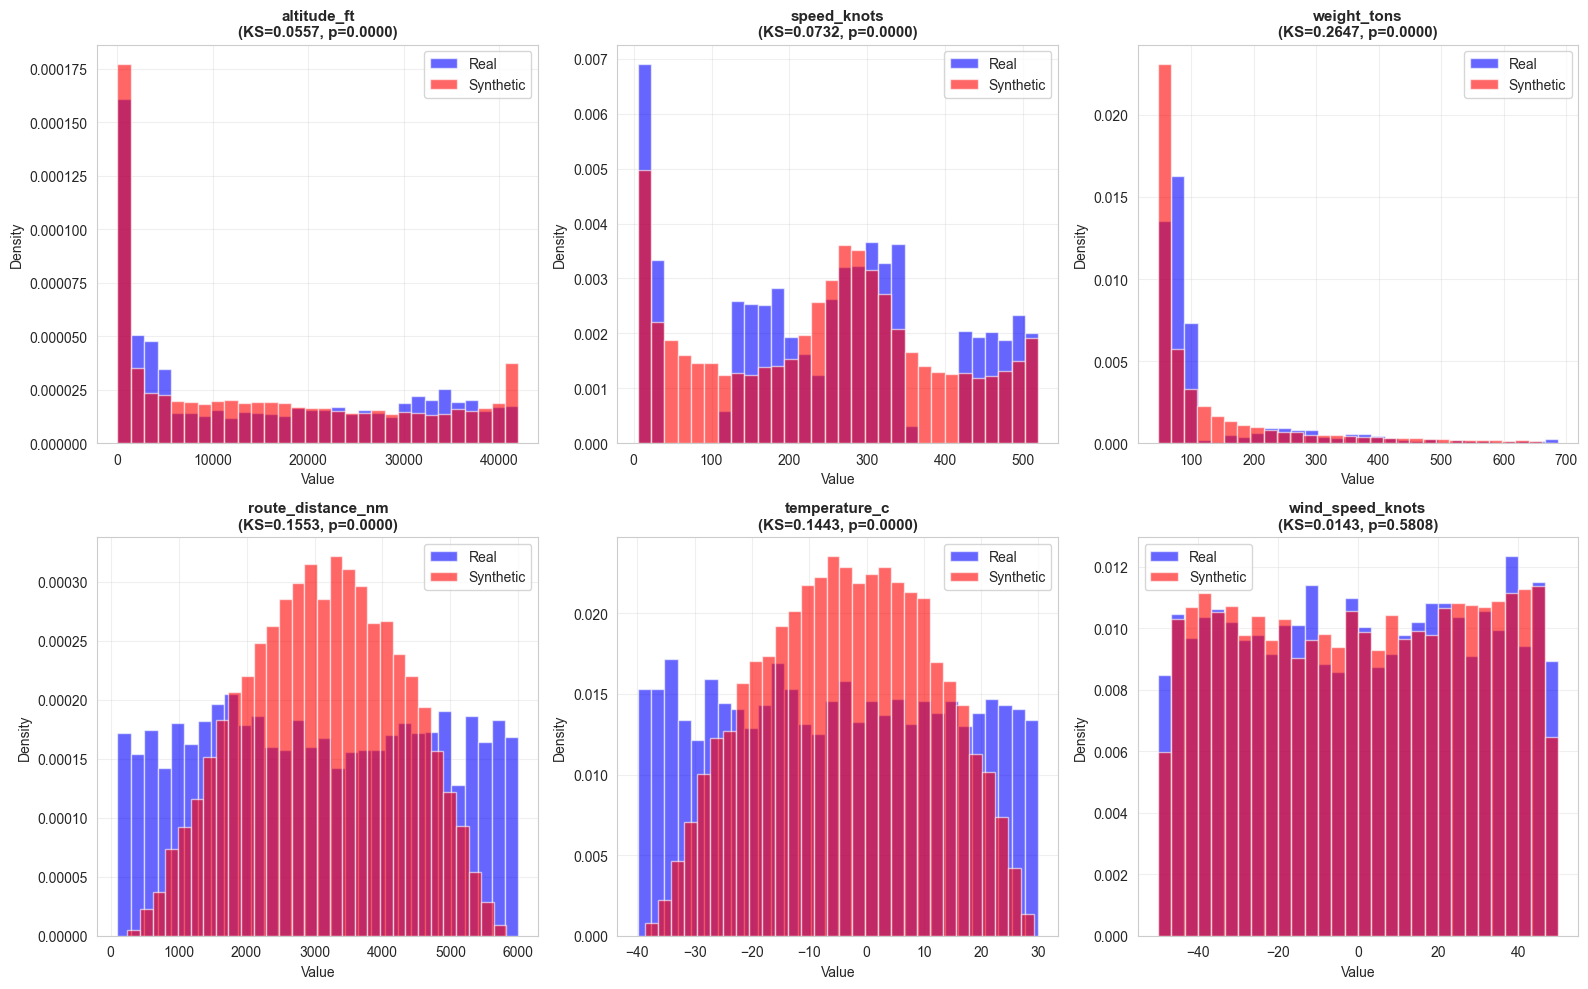

Distribution comparison plots saved!


In [9]:
# Distribution comparison plots
num_plots = min(6, len(ks_results))
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx in range(num_plots):
    ax = axes[idx]
    col = ks_results.iloc[idx]['Feature']
    ks_stat = ks_results.iloc[idx]['KS_Statistic']
    p_val = ks_results.iloc[idx]['P_Value']
    
    # Determine appropriate number of bins based on unique values
    n_unique_real = train_data_unscaled[col].nunique()
    n_unique_synthetic = synthetic_df[col].nunique()
    n_bins = min(30, max(10, min(n_unique_real, n_unique_synthetic) // 2))
    
    # For binary columns, use 2-3 bins
    if n_unique_real <= 2:
        n_bins = 3
    
    ax.hist(train_data_unscaled[col], bins=n_bins, alpha=0.6, label='Real', color='blue', density=True)
    ax.hist(synthetic_df[col], bins=n_bins, alpha=0.6, label='Synthetic', color='red', density=True)
    
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'{col}\n(KS={ks_stat:.4f}, p={p_val:.4f})', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('../plots/ctgan_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('Distribution comparison plots saved!')

## 7. Save Models & Data

In [13]:
# Create directories
os.makedirs('../models', exist_ok=True)
os.makedirs('../plots', exist_ok=True)

# Save generator (used for generating new samples)
generator_path = '../models/ctgan_generator.keras'
ctgan.generator.save(generator_path)

# Save discriminator as well (for potential future use)
discriminator_path = '../models/ctgan_discriminator.keras'
ctgan.discriminator.save(discriminator_path)

# Save scaling parameters for inverse transform
scaling_params = {
    'data_min': data_min.to_dict(),
    'data_max': data_max.to_dict(),
    'data_range': data_range.to_dict()
}
scaling_path = '../models/scaling_params.pkl'
with open(scaling_path, 'wb') as f:
    pickle.dump(scaling_params, f)

# Save synthetic data
synthetic_path = '../models/synthetic_data.csv'
synthetic_df.to_csv(synthetic_path, index=False)

# Save training history
history_path = '../models/ctgan_training_history.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(history, f)

# Save KS test results
ks_path = '../models/ks_test_results.csv'
ks_results.to_csv(ks_path, index=False)

print('✓ Saved models and data:')
print(f'  - Generator: {generator_path}')
print(f'  - Discriminator: {discriminator_path}')
print(f'  - Scaling parameters: {scaling_path}')
print(f'  - Synthetic data: {synthetic_path}')
print(f'  - Training history: {history_path}')
print(f'  - KS test results: {ks_path}')

✓ Saved models and data:
  - Generator: ../models/ctgan_generator.keras
  - Discriminator: ../models/ctgan_discriminator.keras
  - Scaling parameters: ../models/scaling_params.pkl
  - Synthetic data: ../models/synthetic_data.csv
  - Training history: ../models/ctgan_training_history.pkl
  - KS test results: ../models/ks_test_results.csv


## 8. Summary

In [15]:
print('\n' + '='*70)
print('CTGAN TRAINING SUMMARY')
print('='*70)
print(f'\nDataset:')
print(f'  Real training samples: {num_real_samples:,}')
print(f'  Synthetic samples generated: {num_synthetic_samples:,}')
print(f'  Augmentation factor: 5.0x')
print(f'  Features: {data_dim}')

print(f'\nModel Configuration:')
print(f'  Generator: {data_dim} features from 100-D noise')
print(f'  Discriminator: Wasserstein critic')
print(f'  Loss: Wasserstein + Gradient Penalty')
print(f'  Training epochs: 100')
print(f'  Batch size: 256')
print(f'  Critic iterations: 5/generator')

print(f'\nTraining Results:')
print(f'  Final Generator Loss: {history["g_loss"][-1]:.4f}')
print(f'  Final Discriminator Loss: {history["d_loss"][-1]:.4f}')
print(f'  Final Wasserstein Distance: {history["w_distance"][-1]:.4f}')
print(f'  Final Gradient Penalty: {history["gp"][-1]:.4f}')

print(f'\nSynthetic Data Quality:')
print(f'  KS Test Pass Rate: {pass_rate:.1f}%')
print(f'  Average KS Statistic: {ks_results["KS_Statistic"].mean():.6f}')
print(f'  Features passing test: {ks_results["Passed"].sum()}/{len(ks_results)}')

print(f'\nCTGAN training complete!')
print(f'\nNext: Run 04_augmented_model_evaluation.ipynb')
print('='*70)


CTGAN TRAINING SUMMARY

Dataset:
  Real training samples: 3,500
  Synthetic samples generated: 17,500
  Augmentation factor: 5.0x
  Features: 26

Model Configuration:
  Generator: 26 features from 100-D noise
  Discriminator: Wasserstein critic
  Loss: Wasserstein + Gradient Penalty
  Training epochs: 100
  Batch size: 256
  Critic iterations: 5/generator

Training Results:
  Final Generator Loss: -1.4180
  Final Discriminator Loss: -0.8142
  Final Wasserstein Distance: -0.9690
  Final Gradient Penalty: 0.0155

Synthetic Data Quality:
  KS Test Pass Rate: 7.7%
  Average KS Statistic: 0.543141
  Features passing test: 2/26

CTGAN training complete!

Next: Run 04_augmented_model_evaluation.ipynb
